<a href="https://colab.research.google.com/github/isanjit3/LungCancer/blob/master/Lung_Cancer_Segmentation_NSCLS_Radiomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [0]:
#Specify if you want to enable the test code. 
#When you run entire notebook, set it to false.
global_is_test = False

In [0]:
#Mount google Drive.
from google.colab import drive
drive.mount('/gdrive')

#install required packages
!pip3 install pydicom
!pip3 install dicom_contour


# Get data files


## Copy files from Google Drive

In [0]:
#unzip the data fromthe google drive to the VM
#if not global_is_test:
  #!unzip '/gdrive/My Drive/Lung/lung-full.zip' -d  '/content/lung/'

#Partial data set
#if global_is_test:
  #!unzip '/gdrive/My Drive/Lung/lung-partial.zip' -d  '/content/lung/'

#!unzip '/gdrive/My Drive/Lung/lung.zip' -d  '/content/lung/'
#!unzip '/gdrive/My Drive/Lung/lung-test.zip' -d  '/content/lung/lung-test/'

import os
import pydicom
import numpy as np
import dicom_contour.contour as dcm
import matplotlib.pyplot as plt

slices_imgpath_dict = {}
slice_orders = []
#from dicom_contour import *

In [0]:
#Delete bad data sets
#!rm -rf '/content/lung/LUNG1-095'

# Define required methods

##Convert Hounsfield Unit to Pixels 
The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [0]:
#This method returns the image in the HU Units
def parse_dicom_file(fileName):
  """Parse the given DICOM filename
    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """
  try:
    dcm = pydicom.read_file(fileName)
    dcm_image = dcm.pixel_array

    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    dcm_image = dcm_image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    dcm_image[dcm_image == -2000] = 0

    try:
        intercept = dcm.RescaleIntercept        
    except AttributeError:        
        intercept = 0.0

    try:
        slope = dcm.RescaleSlope        
    except AttributeError:        
        slope = 0.0
    
    if slope != 1:
      dcm_image = slope * dcm_image.astype(np.float64)
      dcm_image = dcm_image.astype(np.int16)            
      dcm_image += np.int16(intercept)

    return np.array(dcm_image, dtype=np.int16)

  except:
    return None




In [0]:
def get_roi_contour_ds(rt_sequence, index):
    """
    Extract desired Regions of Interest(ROI) contour datasets
    from RT Sequence.
    
    E.g. rt_sequence can have contours for different parts of the lung
    
    You can use get_roi_names to find which index to use
    
    Inputs:
        rt_sequence (pydicom.dataset.FileDataset): Contour file dataset, what you get 
                                                after reading contour DICOM file
        index (int): Index for ROI Sequence
    Return:
        contours (list): list of ROI contour pydicom.dataset.Dataset s
    """
    if (len(rt_sequence.ROIContourSequence) == 0):
      return []

    # index 0 means that we are getting RTV information
    ROI = rt_sequence.ROIContourSequence[index]
    # get contour datasets in a list
    contours = [contour for contour in ROI.ContourSequence]
    return contours


In [0]:
def contour2poly(contour_dataset, path,slices_imgpath_dict):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (pydicom.dataset.Dataset) : DICOM dataset class that is identified as
                        (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    
    if (img_ID not in slices_imgpath_dict):
      print("Image ID:", img_ID, "not found in the slice image path dict.")
      return;
    
    img = pydicom.read_file(os.path.join(path, slices_imgpath_dict[img_ID]))
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])

    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient

    # y, x is how it's mapped
    pixel_coords = [(np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing))  for x, y, _ in coord]
    return pixel_coords, img_ID, img_shape

In [0]:
def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
    in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

In [0]:
def get_mask_dict(contour_datasets, path, slices_imgpath_dict):
    """
    Inputs:
        contour_datasets (list): list of pydicom.dataset.Dataset for contours
        path (str): path of directory with images

    Return:
        img_contours_dict (dict): img_id : contour array pairs
    """
    
    from collections import defaultdict
    
    # create empty dict for 
    img_contours_dict = defaultdict(int)

    for cdataset in contour_datasets:
        coords, img_id, shape = contour2poly(cdataset, path, slices_imgpath_dict) or (None, None, None)
        if coords is None:
          continue
          
        mask = poly_to_mask(coords, *shape)
        img_contours_dict[img_id] += mask
    
    return img_contours_dict

In [0]:
def get_img_mask_voxel(slice_orders, mask_dict, image_path, slices_imgpath_dict):
    """ 
    Construct image and mask voxels
    
    Inputs:
        slice_orders (list): list of tuples of ordered img_id and z-coordinate position
        mask_dict (dict): dictionary having img_id : contour array pairs
        image_path (str): directory path containing DICOM image files
    Return: 
        img_voxel: ordered image voxel for CT/MR
        mask_voxel: ordered mask voxel for CT/MR
    """
    
    img_voxel = []
    mask_voxel = []
    tumor_only_slices = []
    for img_id, _ in slice_orders:
        path = os.path.join(image_path, slices_imgpath_dict[img_id])
        img_array = parse_dicom_file(path)
        
        if img_id in mask_dict: 
          mask_array = mask_dict[img_id]
          if (np.count_nonzero(mask_array) > 0):
            tumor_only_slices.append(1)
          else:
            tumor_only_slices.append(0)
        else: 
          mask_array = np.zeros_like(img_array)
          tumor_only_slices.append(0)
          
        img_voxel.append(img_array)
        mask_voxel.append(mask_array)
        
    return img_voxel, mask_voxel, tumor_only_slices


In [0]:
def show_img_msk_fromarrayX(img_arr, msk_arr, alpha=0.35, sz=7, cmap='inferno',
                           save_path=None):

    """
    Show original image and masked on top of image
    next to each other in desired size
    Inputs:
        img_arr (np.array): array of the image
        msk_arr (np.array): array of the mask
        alpha (float): a number between 0 and 1 for mask transparency
        sz (int): figure size for display
        save_path (str): path to save the figure
    """

    msk_arr = np.ma.masked_where(msk_arr == 0, msk_arr)
    plt.figure(figsize=(sz, sz))
    plt.subplot(1, 2, 1)
    plt.imshow(img_arr, cmap='gray')
    plt.imshow(msk_arr, cmap=cmap, alpha=alpha)
    plt.subplot(1, 2, 2)
    plt.imshow(img_arr, cmap='gray')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

In [0]:
def slice_order(path):
    """
    Takes path of directory that has the DICOM images and returns
    a ordered list that has ordered filenames
    Inputs
        path: path that has .dcm images
    Returns
        ordered_slices: ordered tuples of filename and z-position
    """
    # handle `/` missing
    if path[-1] != '/': path += '/'
    slices = []
    slices_img_path = {}
    for s in os.listdir(path):
        try:
            f = pydicom.read_file(path + '/' + s)
            f.pixel_array  # to ensure not to read contour file
            slices.append(f)
            slices_img_path[f.SOPInstanceUID] = s
        except:
            continue

    slice_dict = {s.SOPInstanceUID: s.ImagePositionPatient[-1] for s in slices}
    ordered_slices = sorted(slice_dict.items(), key=dcm.operator.itemgetter(1))
    return ordered_slices,slices_img_path

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax


In [0]:
def get_scan_mask_data(image_path, contour_filename, return_tumor_only_slices = True):
  # read dataset for contour
  rt_sequence = pydicom.read_file(contour_filename)

  # get contour datasets with index idx
  idx = 0
  contour_datasets = get_roi_contour_ds(rt_sequence, idx)

  # get slice orders
  slice_orders, slices_imgpath_dict = slice_order(image_path)

 
  # construct mask dictionary
  mask_dict = get_mask_dict(contour_datasets, image_path, slices_imgpath_dict)

  # get image and mask data for patient
  img_data, mask_data, tumor_only_slices = get_img_mask_voxel(slice_orders, mask_dict, image_path, slices_imgpath_dict)
  if return_tumor_only_slices and (1 in tumor_only_slices):  
    idx = tumor_only_slices.index(1)  
    ldx = max(idx for idx, val in enumerate(tumor_only_slices) if val == 1) 
    return img_data[idx:ldx], mask_data[idx:ldx] # Return only the tumor slices
  else: 
    return img_data, mask_data
  

In [0]:
def get_roi_names(contour_data):
    """
    This function will return the names of different contour data,
    e.g. different contours from different experts and returns the name of each.
    Inputs:
        contour_data (dicom.dataset.FileDataset): contour dataset, read by dicom.read_file
    Returns:
        roi_seq_names (list): names of the
    """
    roi_seq_names = [roi_seq.ROIName for roi_seq in list(contour_data.StructureSetROISequence)]
    return roi_seq_names

In [0]:
def show_img_msk_fromarray(img_arr, msk_arr, alpha=0.35, sz=7, cmap='inferno',
                           save_path=None):

    """
    Show original image and masked on top of image
    next to each other in desired size
    Inputs:
        img_arr (np.array): array of the image
        msk_arr (np.array): array of the mask
        alpha (float): a number between 0 and 1 for mask transparency
        sz (int): figure size for display
        save_path (str): path to save the figure
    """

    #msk_arr = np.ma.masked_where(msk_arr == 0, msk_arr)
    plt.figure(figsize=(sz, sz))
    plt.subplot(1, 2, 1)
    plt.imshow(img_arr, cmap='gray')
    #plt.imshow(msk_arr, cmap=cmap, alpha=alpha)
    #plt.imshow(msk_arr, cmap='jet', interpolation='none', alpha=None)
    plt.subplot(1, 2, 2)
    #plt.imshow(img_arr, cmap='gray')
    plt.imshow(msk_arr, cmap='jet', interpolation='none', alpha=None)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

In [0]:
def resample_img(image, scan, new_spacing=[1,1,1]):
  """
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance 
between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], 
this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain 
isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we 
can use 3D convnets without worrying about learning zoom/slice thickness invariance.

Whilst this may seem like a very simple step, it has quite some edge cases due to 
rounding. Also, it takes quite a while.
"""
  # Determine current pixel spacing
  spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

  resize_factor = spacing / new_spacing
  new_real_shape = image.shape * resize_factor
  new_shape = np.round(new_real_shape)
  real_resize_factor = new_shape / image.shape
  new_spacing = spacing / real_resize_factor
  
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

  return image, new_spacing

In [0]:

def normalize(image, min_bound, max_bound, pixel_mean):
    image = (image - min_bound) / (max_bound - min_bound)
    image[image>1] = 1.
    image[image<0] = 0.

    #zero center the image so that the mean value is 0
    image = image - pixel_mean
    return image

In [0]:
def get_scan_slices(path):
  slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
  try:
      slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
      slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
  for s in slices:
      s.SliceThickness = slice_thickness
        
  return slices

# Test Code

###Test Code initialization block

In [0]:
  
  image_path = '/content/lung/LUNG1-002/01-01-2014-StudyID-85095/1-61228'
  contour_filename = '/content/lung/LUNG1-002/01-01-2014-StudyID-85095/1-63982/000000.dcm'

In [0]:
if global_is_test:
  # get slice orders
  slice_orders, slices_imgpath_dict = slice_order(image_path)
  
  print(slice_orders[0])
  img_data, mask_data = get_scan_mask_data(image_path, contour_filename)

  #img_data = np.array(img_data)
  #mask_data = np.array(mask_data)

  #print(img_data[5][250])


In [0]:
import scipy.ndimage
if global_is_test:
  #### Full pipeline for getting img - mask data for a patient
  
  # read dataset for contour
  rt_sequence = pydicom.read_file(contour_filename)

  #print(rt_sequence.ROIContourSequence)

  print(get_roi_names(rt_sequence))
  # get contour datasets with index idx
  idx = 0
  contour_datasets = get_roi_contour_ds(rt_sequence, idx)

  # get slice orders
  slice_orders, slices_imgpath_dict = slice_order(image_path)

  # construct mask dictionary
  mask_dict = get_mask_dict(contour_datasets, image_path,slices_imgpath_dict)

  # get image and mask data for patient
  img_data, mask_data, tumor_only_slices = get_img_mask_voxel(slice_orders, mask_dict, image_path, slices_imgpath_dict)

  slices = get_scan_slices(image_path)

  vstack_img = np.dstack(img_data[0:8])
  print(vstack_img.shape)

  np_img = np.asarray(img_data, dtype=np.int16)
  np_mask = np.asarray(mask_data, dtype=np.int8)

   
  plt.hist(img_data[35].flatten(), bins=80, color='c')
  plt.xlabel("Hounsfield Units (HU)")
  plt.ylabel("Frequency")
  plt.show()

  plt.hist(mask_data[35].flatten(), bins=80, color='c')
  plt.xlabel("Hounsfield Units (HU)")
  plt.ylabel("Frequency")
  plt.show()


In [0]:
if global_is_test:
  MIN_BOUND = -1000.0
  MAX_BOUND = 400.0
  PIXEL_MEAN = 0.25  
  """
  resampled_img, new_spacing = resample_img(np_img, slices)
  resampled_mask, new_spacing = resample_img(np_mask, slices)
  
  print("Resampled Image Shape:", resampled_img.shape)
  print("Resampled Mask Shape:", resampled_mask.shape)

     
  plt.hist(resampled_img[35].flatten(), bins=80, color='c')
  plt.xlabel("Hounsfield Units (HU)")
  plt.ylabel("Frequency")
  plt.show()
  """
  norm_img = normalize(np_img, MIN_BOUND, MAX_BOUND, PIXEL_MEAN)
  print(norm_img.shape) 

  print(len(norm_img)//8)
  vstack_img = np.dstack(norm_img[0:8])
  print(vstack_img.shape)

  plt.hist(norm_img[35].flatten(), bins=80, color='c')
  plt.xlabel("Hounsfield Units (HU)")
  plt.ylabel("Frequency")
  plt.show()  

In [0]:
#This block prints the slices that has tumor.
if global_is_test:

  print(tumor_only_slices)

  idx = tumor_only_slices.index(1)
  if (idx > 0):
    ldx = max(idx for idx, val in enumerate(tumor_only_slices) if val == 1) 

  print('First Index:', idx)
  print('Last Index:', ldx)

  middle_slice = round(idx + (ldx - idx) / 2)

  num_slices = 10
  start_slice = round(middle_slice - num_slices/2)
  end_slice = round(middle_slice + num_slices/2)
  #slide_range = range[start_slice, end_slice]

  



In [0]:
if global_is_test:
  for img, mask in zip(img_data, mask_data):
    show_img_msk_fromarray(img, mask, sz=10, cmap='inferno', alpha=0.5)

In [0]:
if global_is_test:
  tumor_slice_count = 0;


  for i,cntr in enumerate(contour_datasets):
    if (np.count_nonzero(cntr) > 0) :
      tumor_slice_count += 1

      plt.imshow(img_data[i], cmap=plt.cm.gray)

      cntr = np.ma.masked_where(cntr == 0, cntr) #mask the zero values.
      plt.imshow(cntr, cmap='jet', interpolation='none', alpha=None)
      plt.show()


  print("Number of slices with Tumor: ", tumor_slice_count)
  #filled_cntr = dcm.fill_contour(cntr)
  #plt.imshow(filled_cntr)

In [0]:
if global_is_test:
  import glob
  import os
  import numpy as np

  INPUT_FOLDER = '/content/lung/'
  study_folders = glob.glob(os.path.join(INPUT_FOLDER, "*", "*"))

  #Split the studies into training dataset and test data sets. (90:10)
  studies = np.array(study_folders)
  np.random.shuffle(studies)
  num_studies = len(studies)

  train_study_folders, test_study_folders = studies[:(int(num_studies * 0.95))], studies[(int(num_studies * 0.95)):]

  print(len(train_study_folders))
  print("--------------------------TEST-----------------------")
  print(len(test_study_folders))

# Get all study data and create Numpy array

In [0]:
def get_study_images(study_folders, load_tumor_only_slices = True):  
  x=[]
  y=[]
  x_temp = []
  y_temp = []
  for si, sf in enumerate(study_folders):
    scan_folders = glob.glob(os.path.join(sf, "*"))
    
    if (len(scan_folders) == 2):
      scan_image_path = ''
      contour_file_name = ''
      scan = os.listdir(scan_folders[0])[0]
      file_name = os.path.join(scan_folders[0], scan)
    
      try:
        dicom_file = pydicom.read_file(file_name)     
        dicom_file.pixel_array #Check if this is scan file.
        scan_image_path = scan_folders[0]
        contour_file_name = os.path.join(scan_folders[1], os.listdir(scan_folders[1])[0])      
      except:
        #This is contour file.     
        scan_image_path = scan_folders[1]     
        contour_file_name = file_name     
      
      print('Processing Scan path: ', scan_image_path)       
      img_data, mask_data = get_scan_mask_data(scan_image_path, contour_file_name, load_tumor_only_slices)
      print("Scan Image length:", len(img_data))
      #Convert to numpy array for easy processing.
      np_img = np.asarray(img_data, dtype=np.float16)
      np_mask = np.asarray(mask_data, dtype=np.int8)

      np_img = normalize(np_img, MIN_BOUND, MAX_BOUND, PIXEL_MEAN)
      #Plot the tumor slices.
      #for img, mask in zip(img_data, mask_data):
      #  show_img_msk_fromarray(img, mask, sz=10, cmap='inferno', alpha=0.5)

      for i in range(0, len(np_img)):
        x_temp.append(np_img[i])
        y_temp.append(np_mask[i])
        
        if (len(x_temp) == 8):
          x_temp = np.array(x_temp)
          y_temp = np.array(y_temp)
          x.append(np.dstack(x_temp[0:8]))
          y.append(np.dstack(y_temp[0:8]))
          x_temp = []
          y_temp = []
      
      #TODO: Create 3D array of 512x512x8
      #Number of whole batches
      """
      batch_count = len(np_img)//8
      print("Batch: ", batch_count)
      for i in range(0, batch_count):
        x.append(np.dstack(np_img[i*8 : (i+1)*8]))
        y.append(np.dstack(np_mask[i*8 : (i+1)*8]))        
      """
  return np.array(x), np.array(y)


In [0]:
import glob
INPUT_FOLDER = '/content/lung/'
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 8
IMG_NUM_IMAGES_PER_STUDY = 10

MIN_BOUND = -900.0 #Minimum HU value we care about
MAX_BOUND = 400.0 #Max HU value we care about.
PIXEL_MEAN = 0.25  

study_folders = glob.glob(os.path.join(INPUT_FOLDER, "*", "*"))

#Split the studies into training dataset and test data sets. 
studies = np.array(study_folders)
np.random.shuffle(studies)
num_studies = len(studies)

#split the studies
train_study_folders, test_study_folders = studies[:(int(num_studies * 0.95))], studies[(int(num_studies * 0.95)):]
if os.path.exists('model-lung-segmentation.h5'):
  print("Model already exists. Not loading training and validation datasets.")
else:
  X_train,  Y_train = get_study_images(train_study_folders) 
  
X_test,Y_test   = get_study_images(test_study_folders, False) 

Model already exists. Not loading training and validation datasets.
Processing Scan path:  /content/lung/LUNG1-273/07-11-2008-StudyID-25746/0-83208
Scan Image length: 136
Processing Scan path:  /content/lung/LUNG1-296/10-03-2008-StudyID-14251/0-37234
Scan Image length: 133
Processing Scan path:  /content/lung/LUNG1-214/10-29-2007-StudyID-03062/0-29876
Scan Image length: 105
Processing Scan path:  /content/lung/LUNG1-044/01-01-2014-StudyID-08675/1-41615
Scan Image length: 99
Processing Scan path:  /content/lung/LUNG1-166/02-21-2007-StudyID-46760/0-83514
Scan Image length: 134
Processing Scan path:  /content/lung/LUNG1-047/01-01-2014-StudyID-48192/1-78583
Scan Image length: 110
Processing Scan path:  /content/lung/LUNG1-253/05-08-2008-StudyID-37800/0-29428
Scan Image length: 91
Processing Scan path:  /content/lung/LUNG1-102/03-02-2006-StudyID-37333/0-24638
Scan Image length: 118
Processing Scan path:  /content/lung/LUNG1-045/01-01-2014-StudyID-80075/1-95533
Scan Image length: 108
Process

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
#import neccessary packages
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import *

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

**Build UNET Model**

In [0]:
# Build U-Net model
def build_cnn_unet_model():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.5) (c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.5) (c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.5) (c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.5) (c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(IMG_CHANNELS, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model


In [0]:
#call the function.
model = build_cnn_unet_model()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 8)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 8)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 1168        lambda_1[0][0]                   
__________________________________________________________________________

**Train the Model**

In [0]:
# Fit model
if os.path.exists('model-lung-segmentation.h5'):
  print("Model Already exists. Skipping the training.")
else:
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint('model-lung-segmentation.h5', verbose=1, save_best_only=True)
  results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer], shuffle=True)

Model Already exists. Skipping the training.


# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [0]:
# Predict on train, val and test
model = load_model('model-lung-segmentation.h5', custom_objects={'mean_iou': mean_iou})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (IMG_HEIGHT, IMG_WIDTH), 
                                       mode='constant', preserve_range=True))

226/226 [==============================] - 18s 78ms/step


In [0]:
preds_test_upsampled[0].shape

(226, 512, 512, 8)
(512, 512)


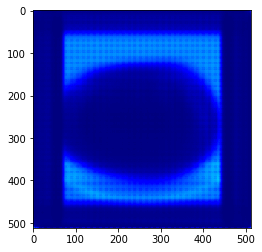

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


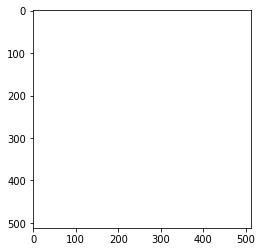

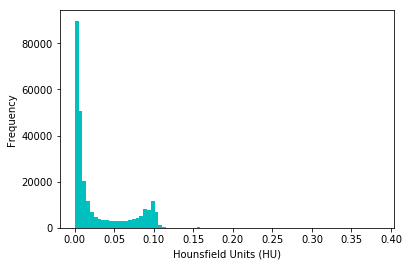

(512, 512)


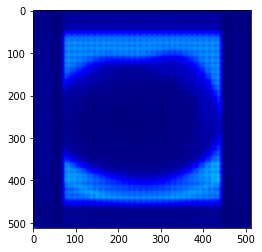

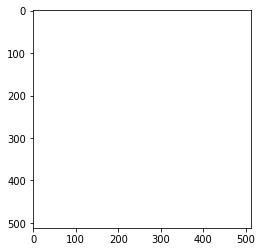

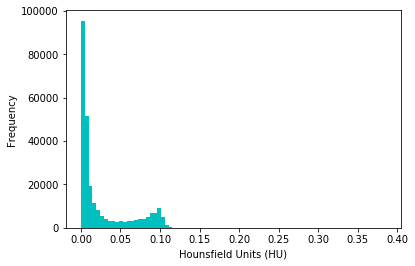

(512, 512)


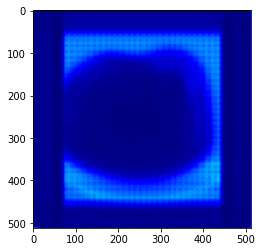

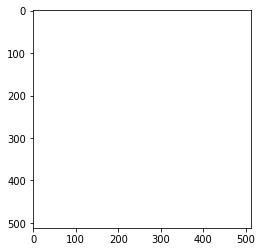

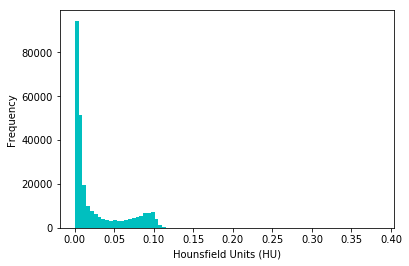

(512, 512)


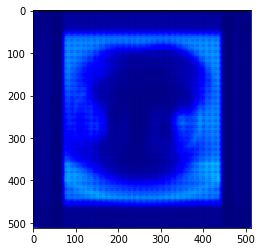

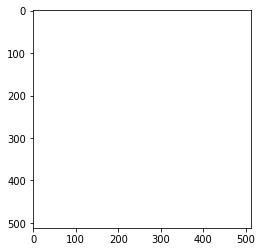

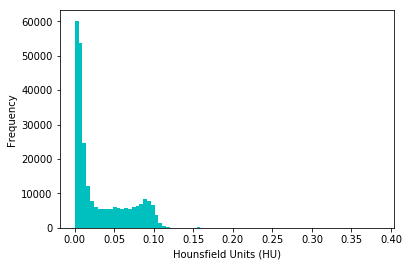

(512, 512)


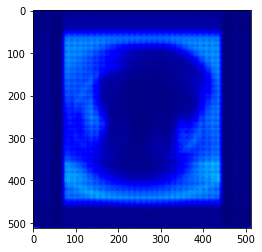

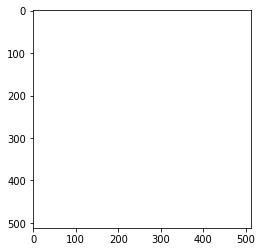

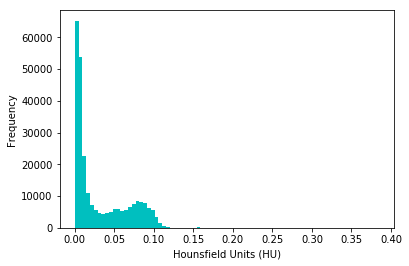

(512, 512)


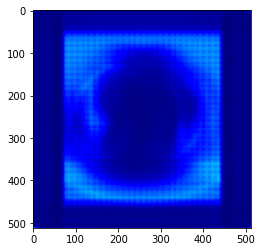

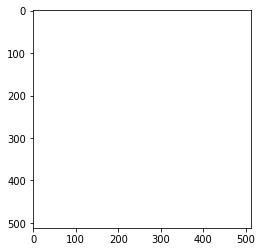

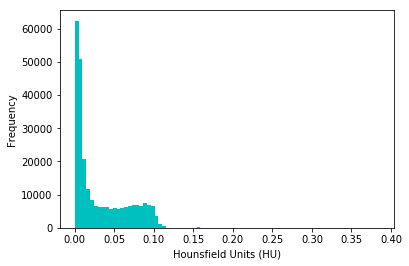

(512, 512)


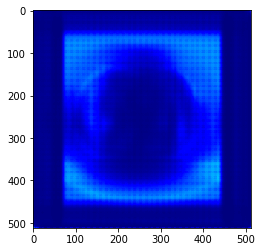

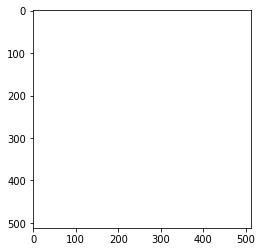

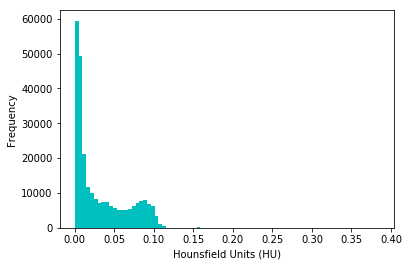

(512, 512)


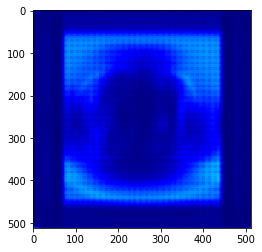

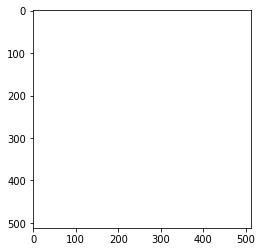

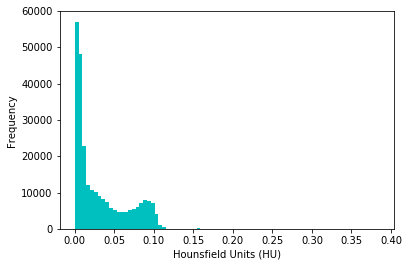

(512, 512)


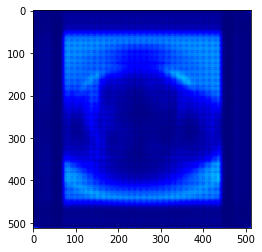

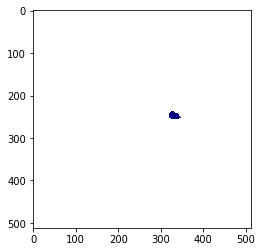

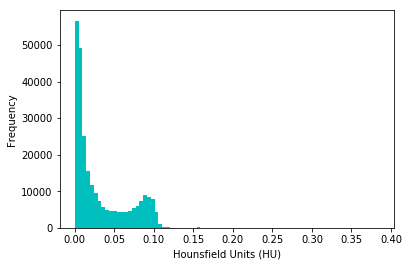

(512, 512)


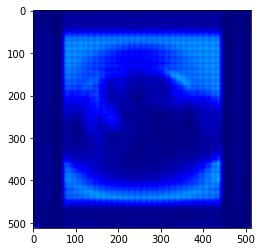

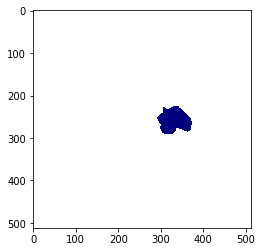

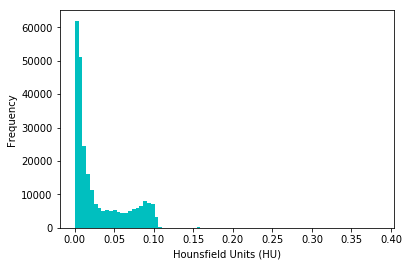

(512, 512)


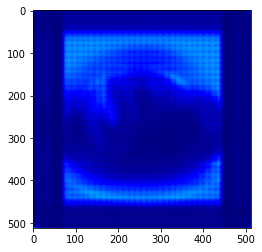

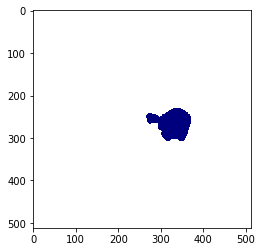

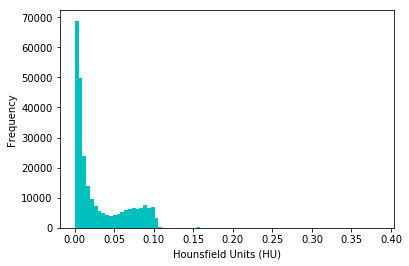

(512, 512)


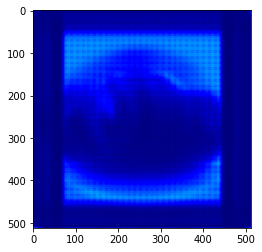

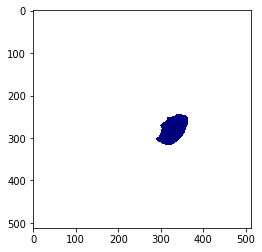

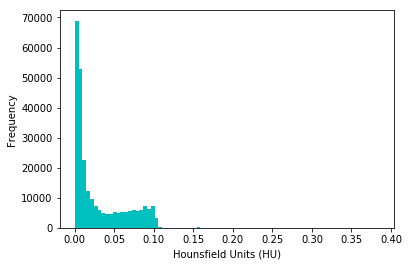

(512, 512)


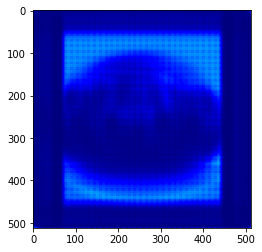

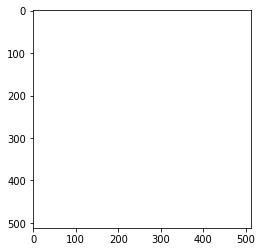

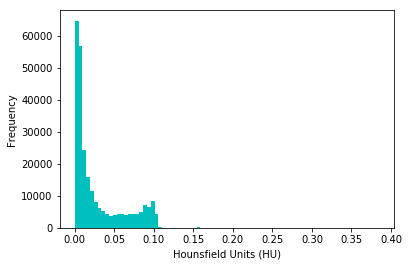

(512, 512)


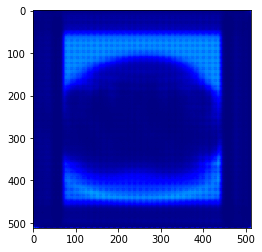

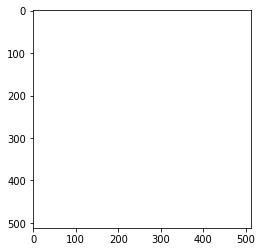

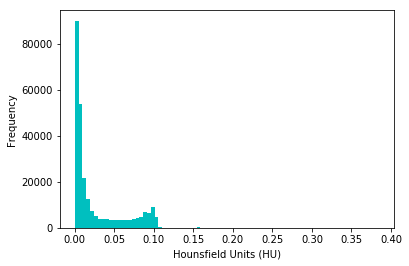

(512, 512)


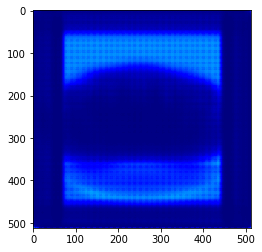

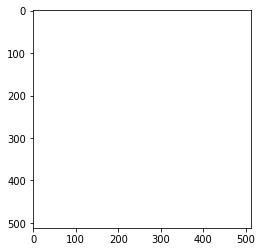

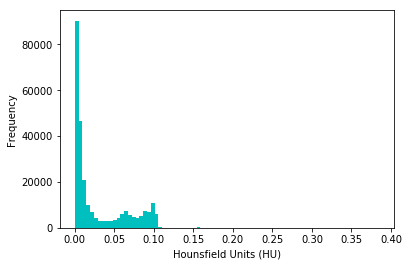

(512, 512)


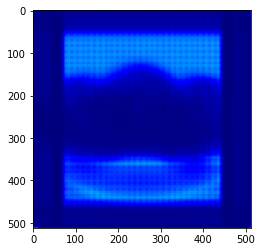

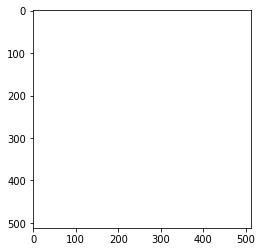

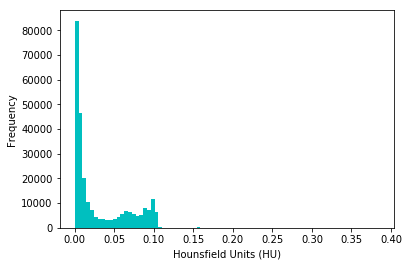

(512, 512)


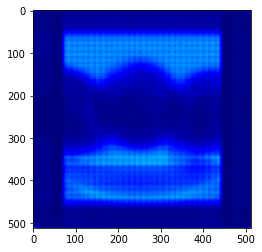

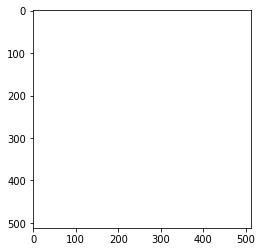

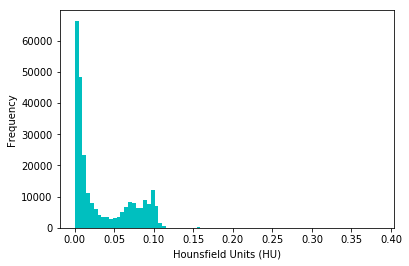

(512, 512)


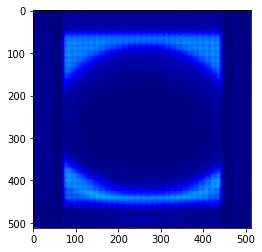

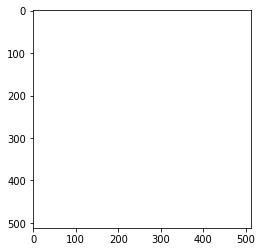

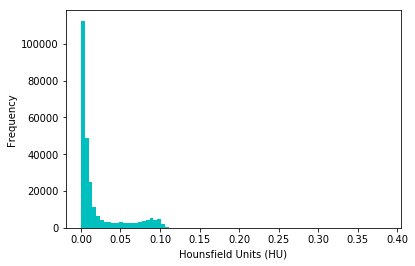

(512, 512)


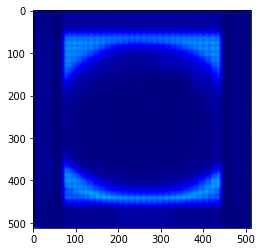

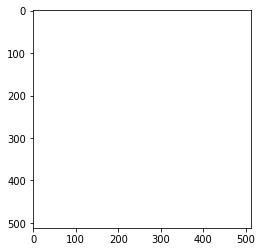

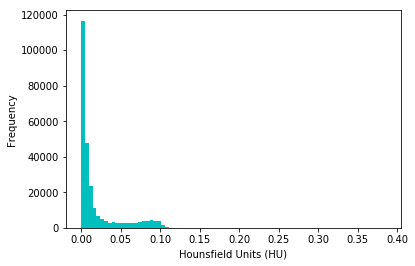

(512, 512)


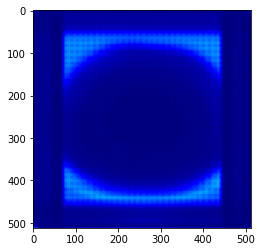

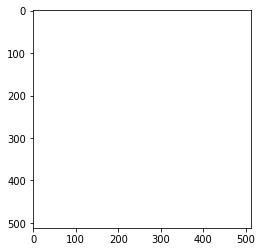

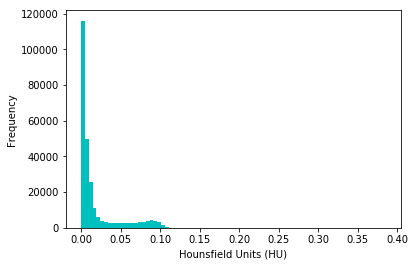

(512, 512)


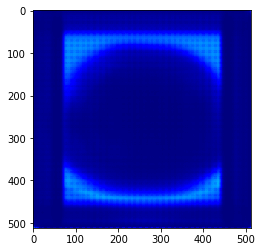

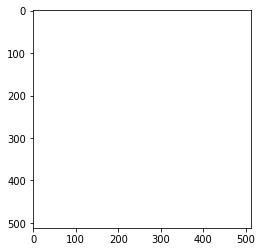

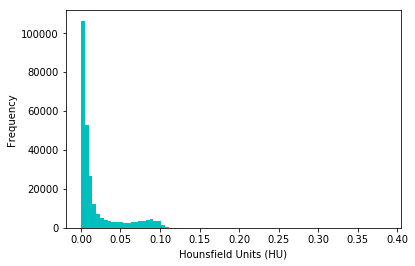

(512, 512)


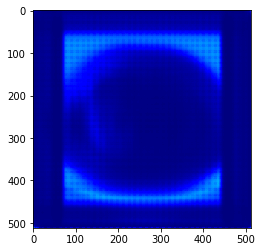

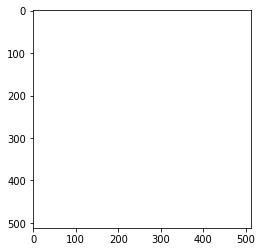

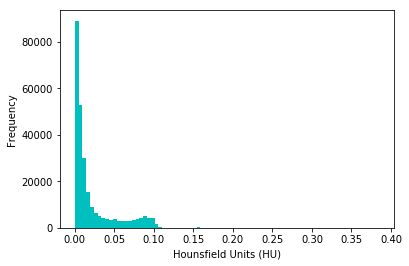

(512, 512)


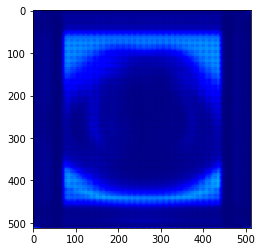

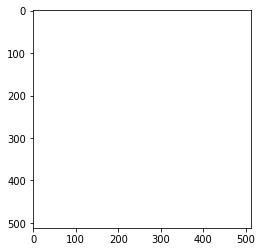

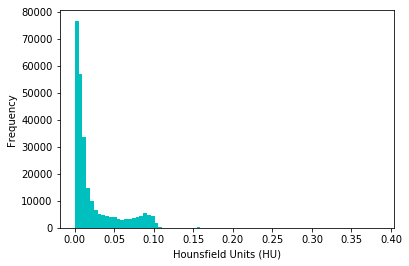

(512, 512)


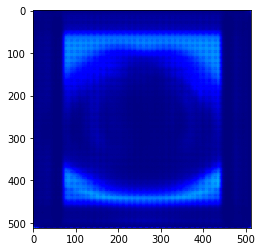

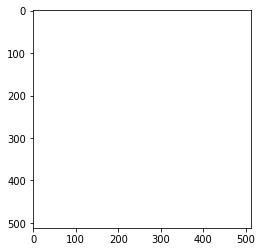

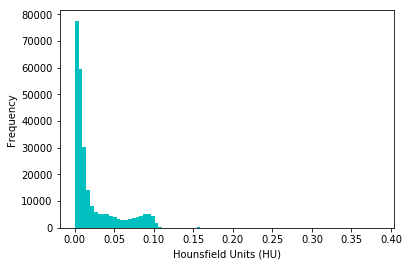

(512, 512)


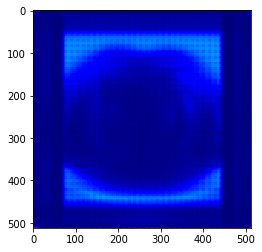

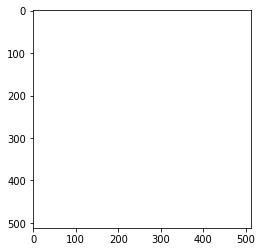

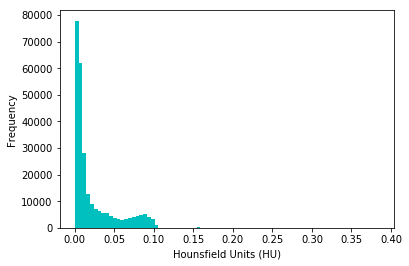

(512, 512)


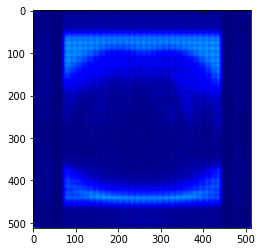

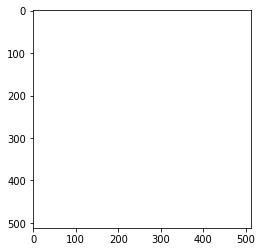

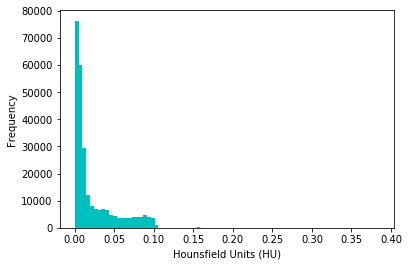

(512, 512)


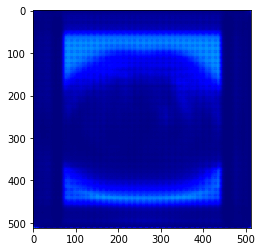

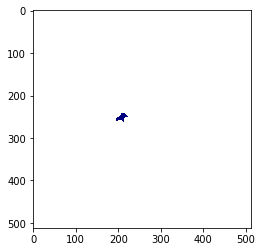

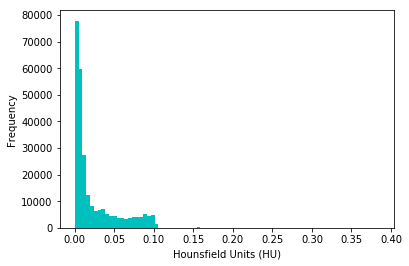

(512, 512)


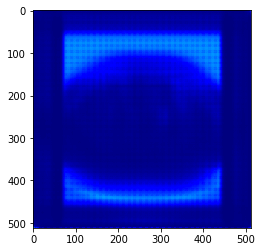

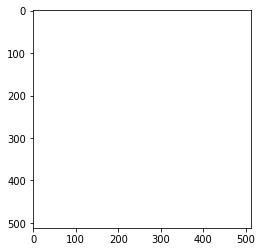

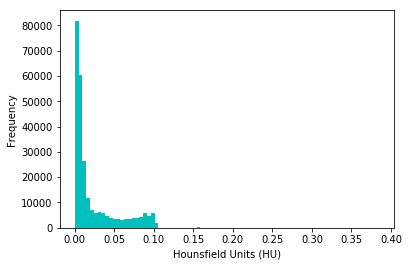

(512, 512)


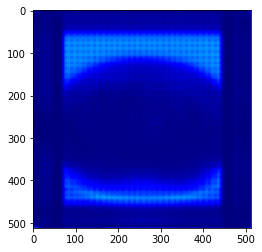

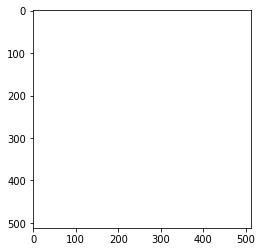

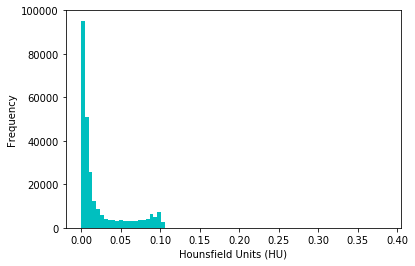

(512, 512)


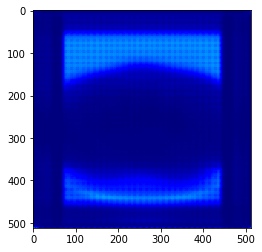

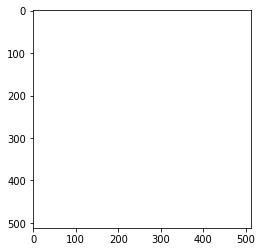

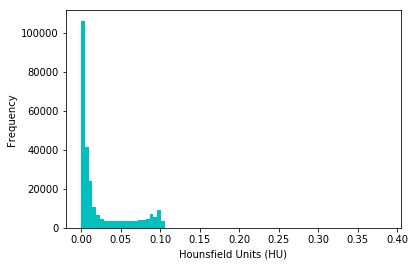

(512, 512)


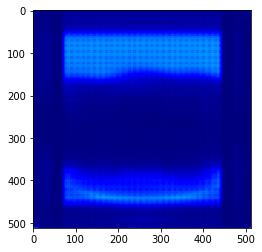

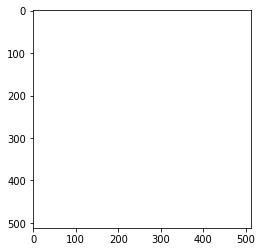

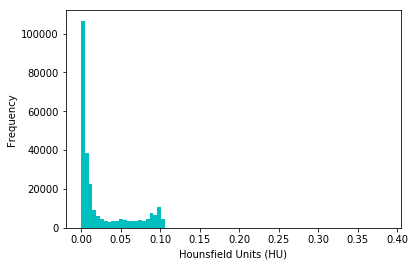

(512, 512)


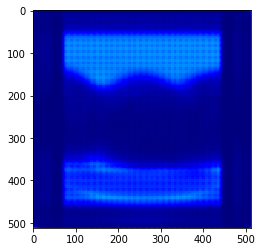

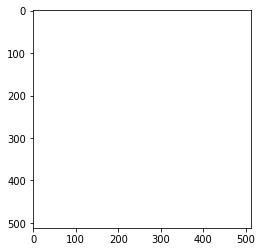

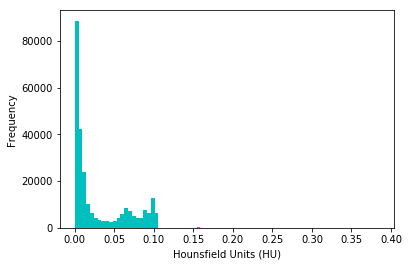

(512, 512)


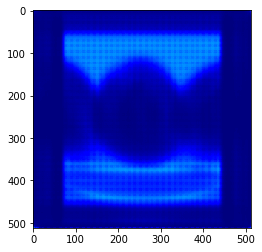

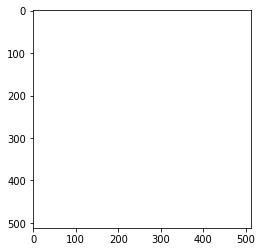

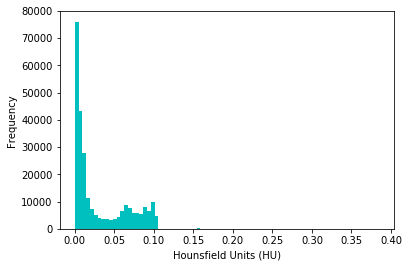

(512, 512)


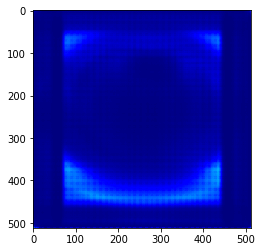

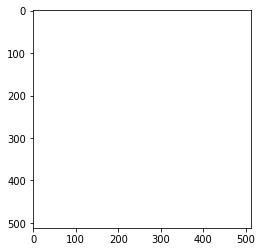

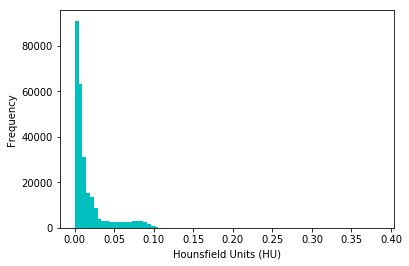

(512, 512)


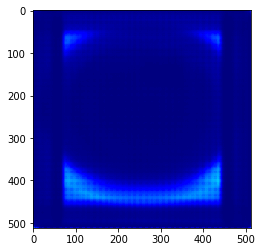

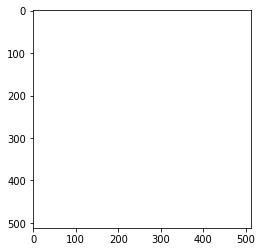

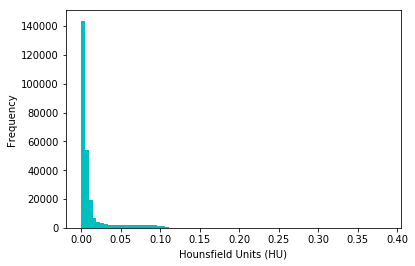

(512, 512)


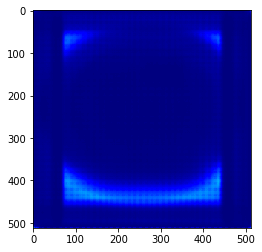

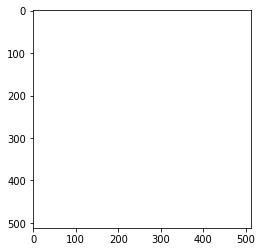

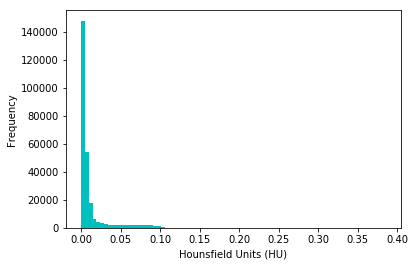

(512, 512)


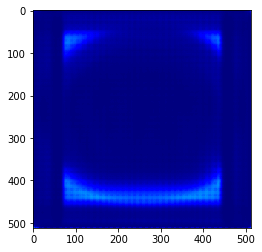

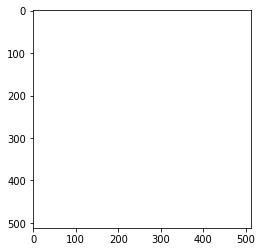

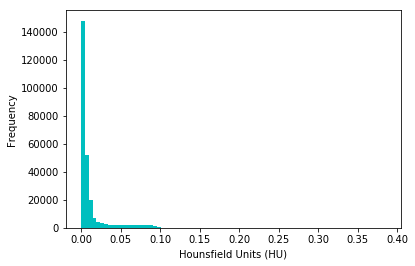

(512, 512)


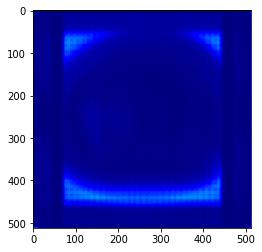

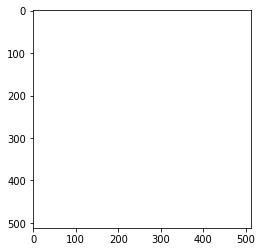

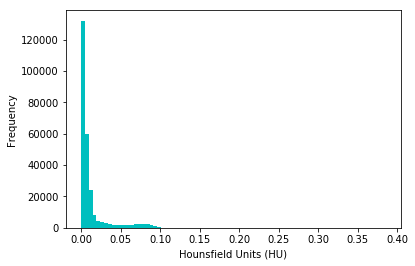

(512, 512)


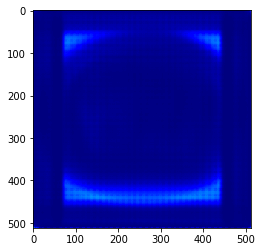

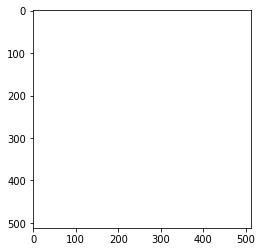

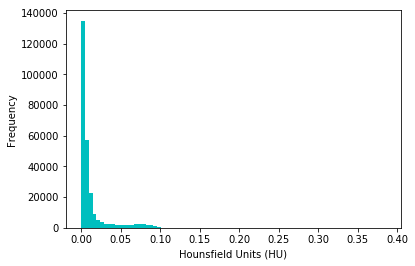

(512, 512)


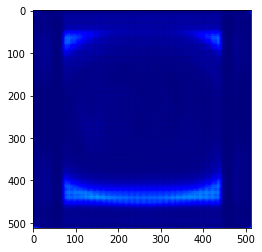

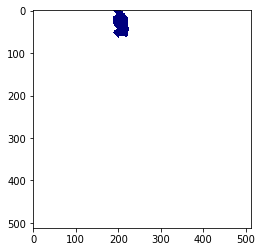

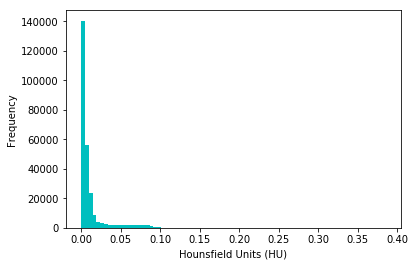

(512, 512)


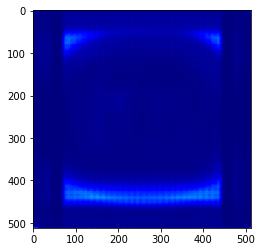

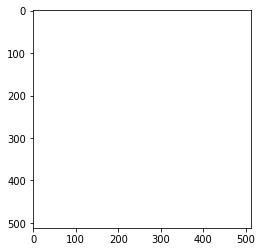

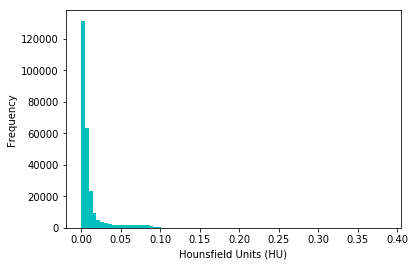

(512, 512)


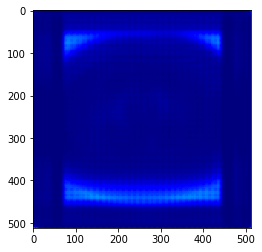

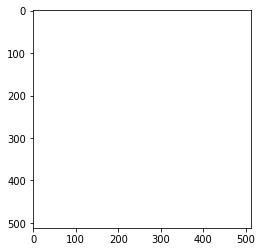

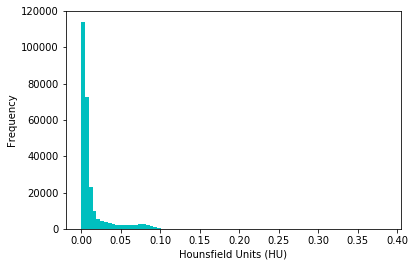

(512, 512)


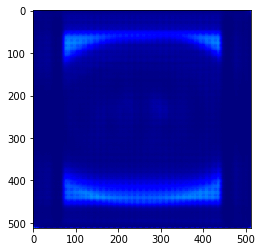

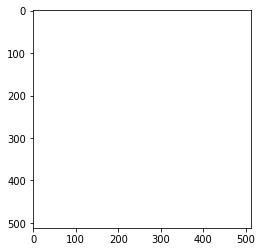

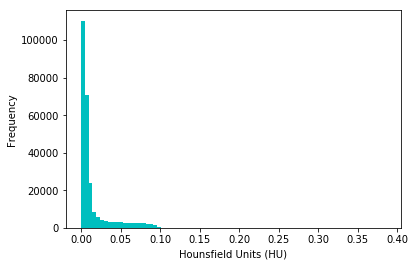

(512, 512)


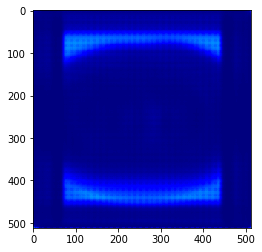

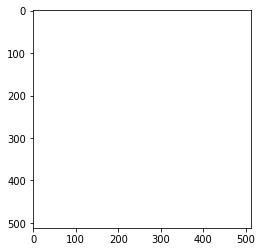

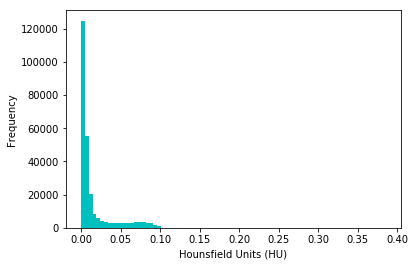

(512, 512)


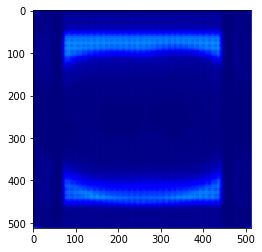

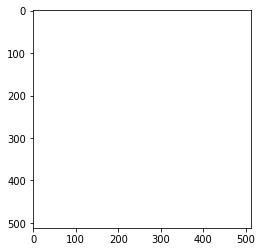

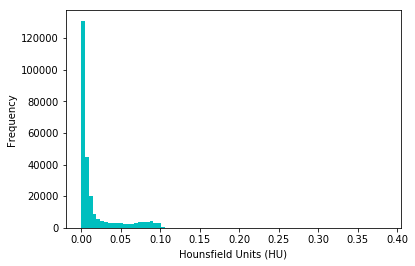

(512, 512)


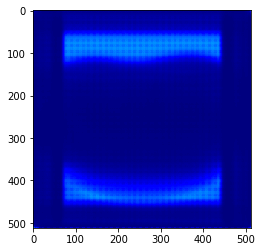

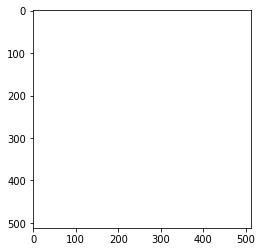

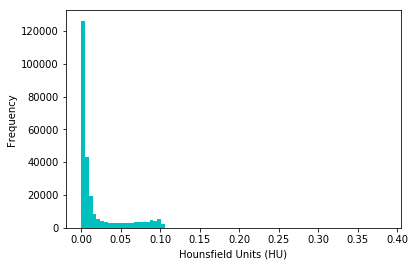

(512, 512)


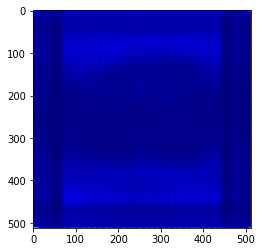

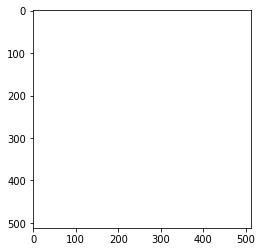

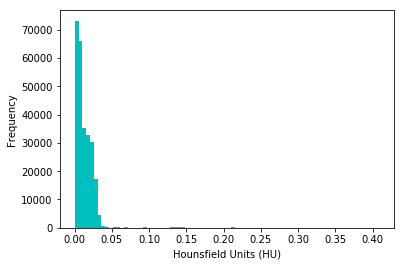

(512, 512)


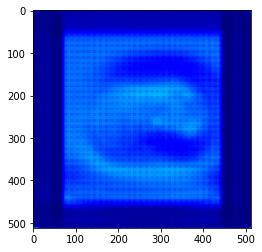

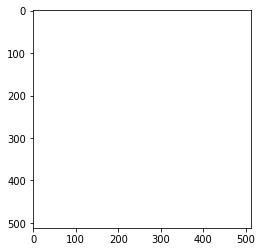

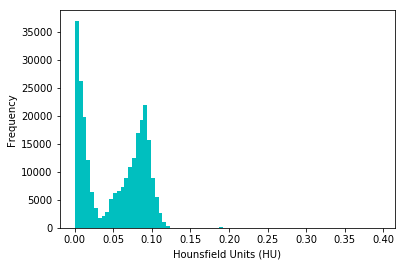

(512, 512)


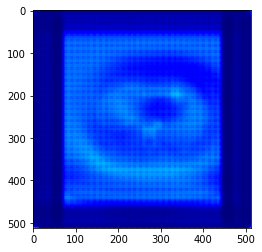

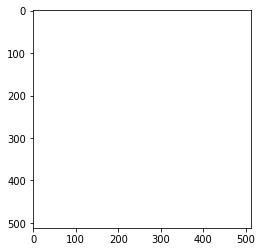

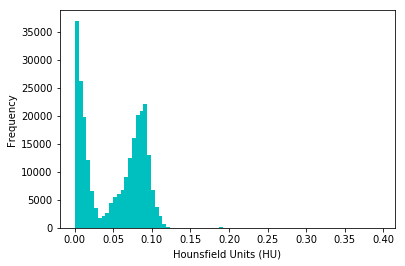

(512, 512)


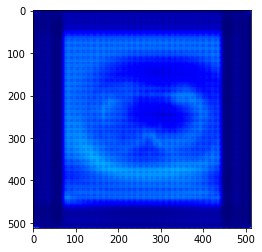

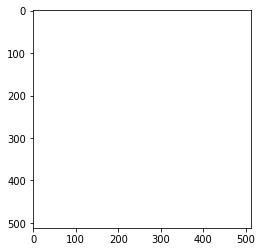

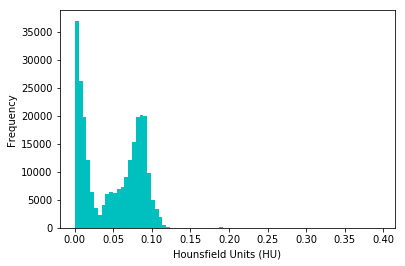

(512, 512)


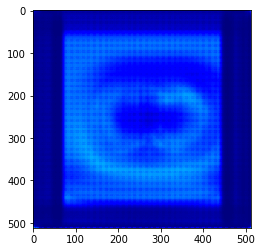

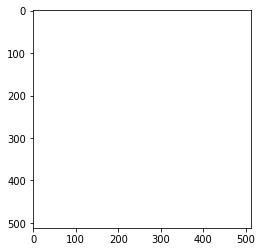

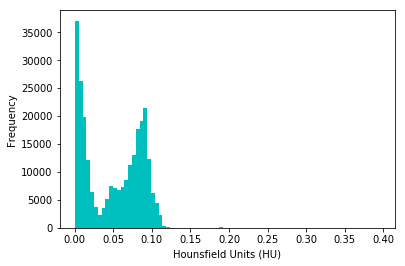

(512, 512)


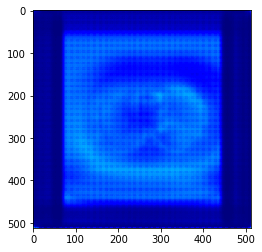

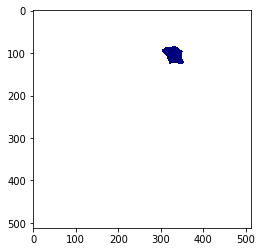

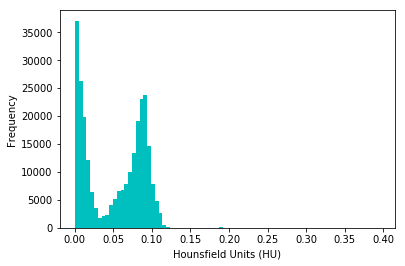

(512, 512)


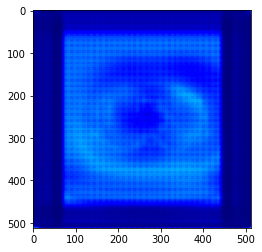

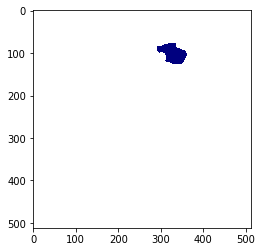

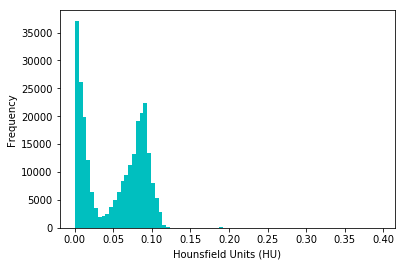

(512, 512)


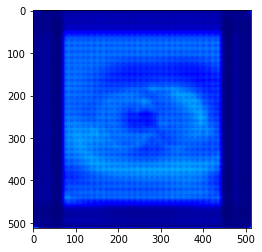

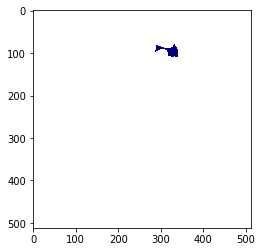

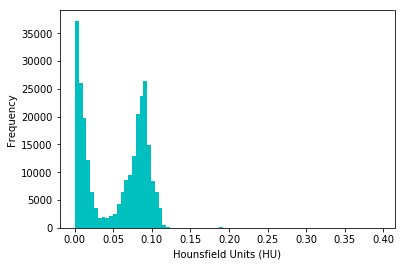

(512, 512)


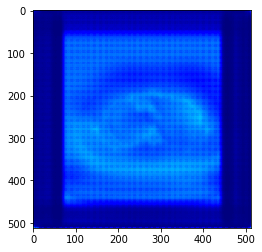

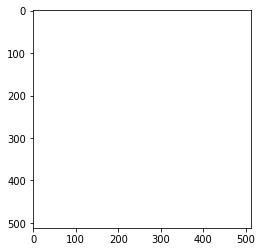

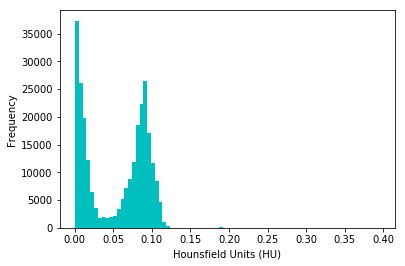

(512, 512)


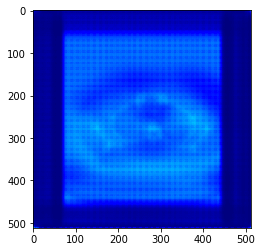

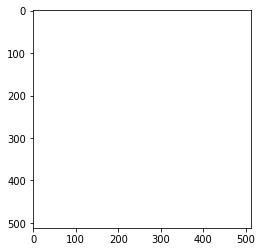

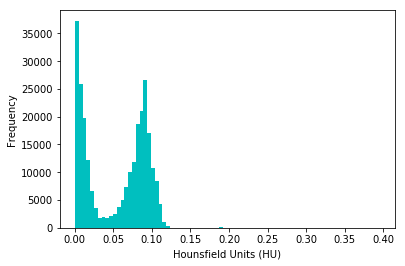

(512, 512)


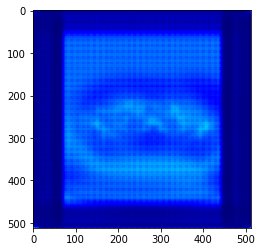

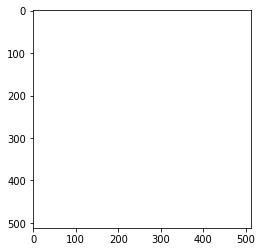

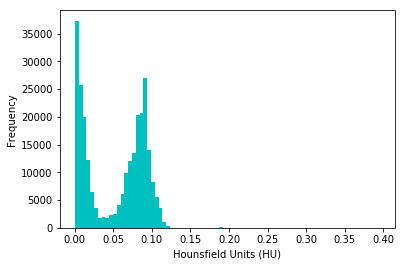

(512, 512)


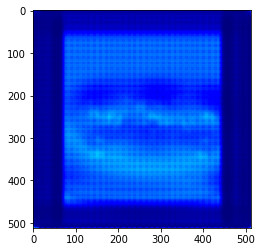

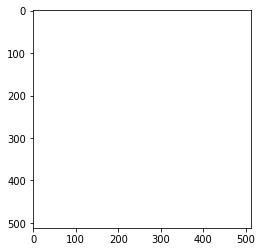

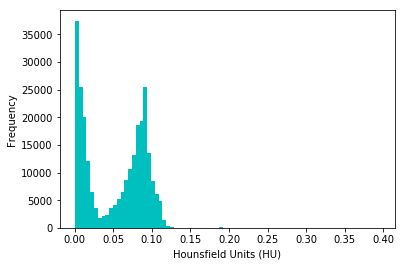

(512, 512)


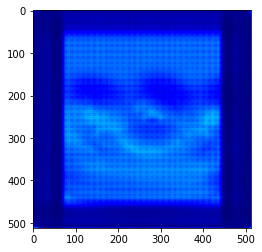

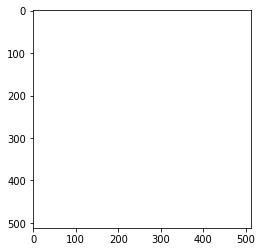

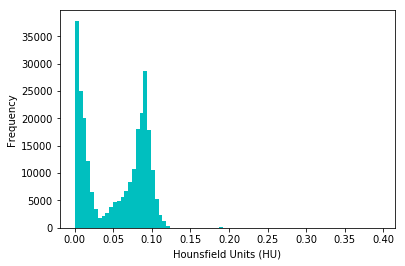

(512, 512)


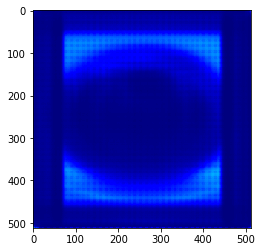

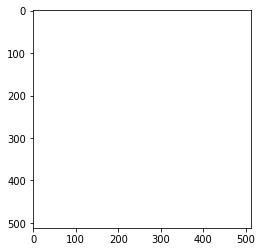

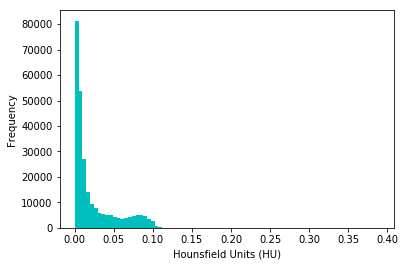

(512, 512)


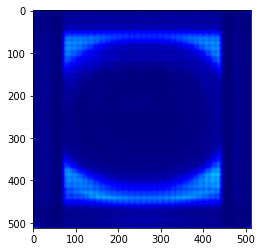

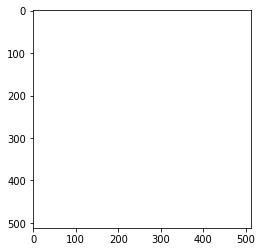

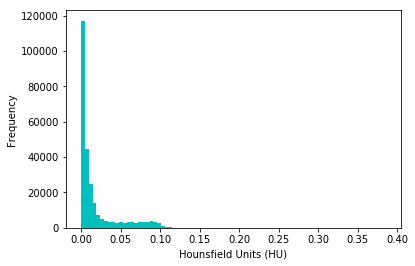

(512, 512)


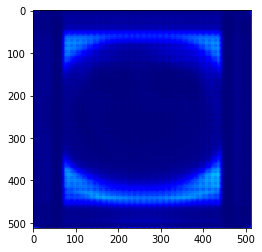

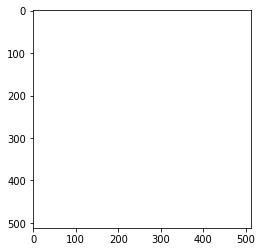

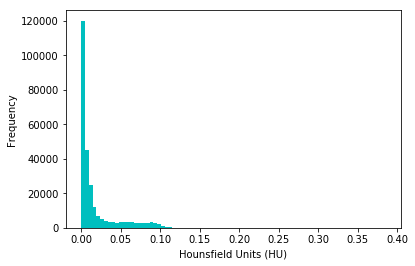

(512, 512)


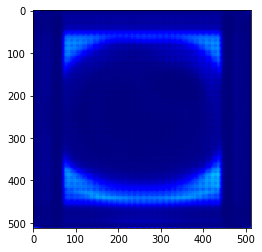

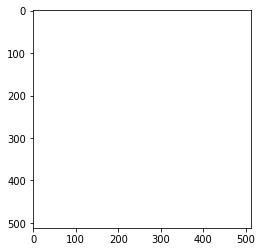

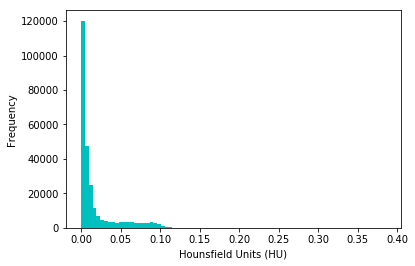

(512, 512)


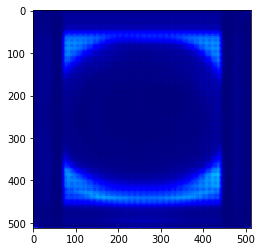

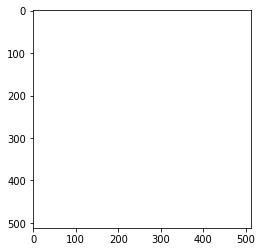

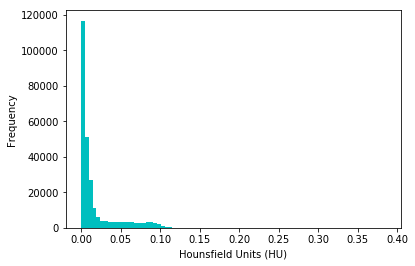

(512, 512)


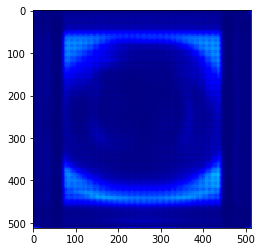

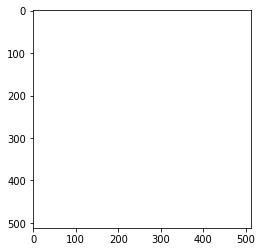

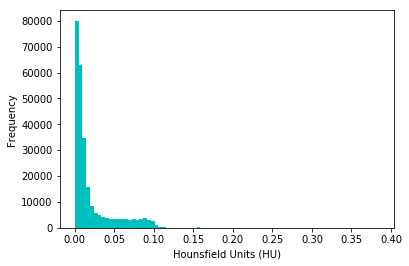

(512, 512)


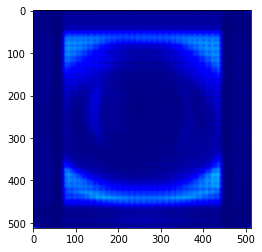

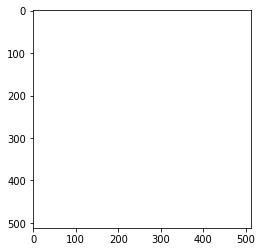

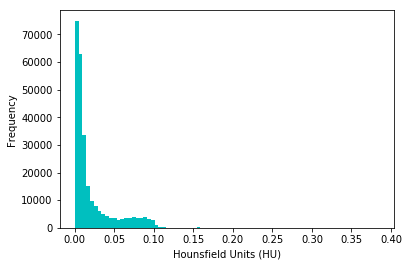

(512, 512)


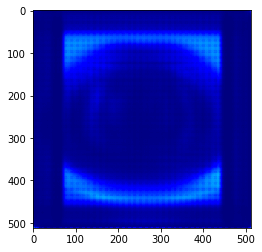

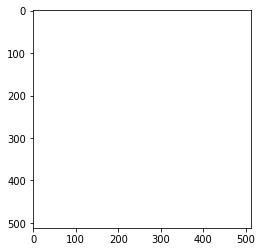

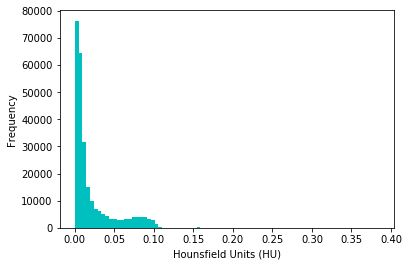

(512, 512)


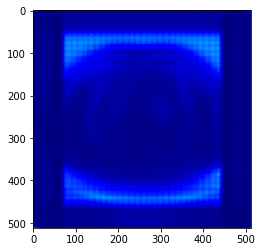

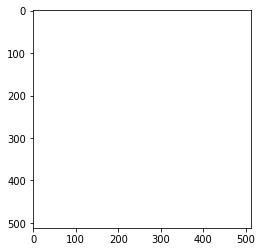

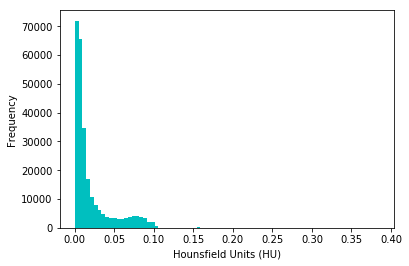

(512, 512)


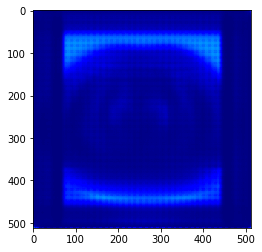

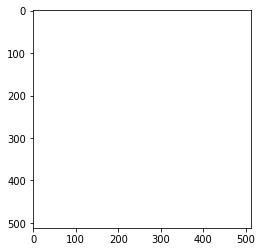

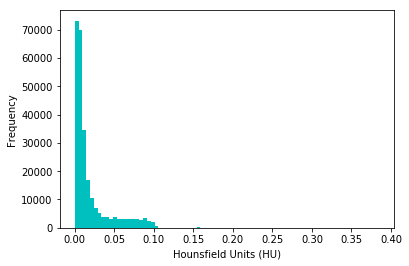

(512, 512)


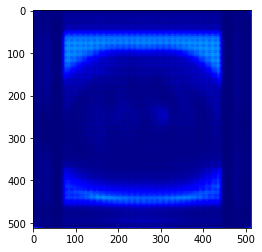

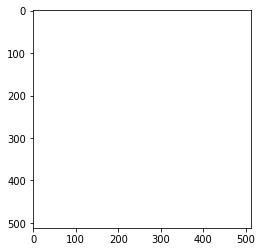

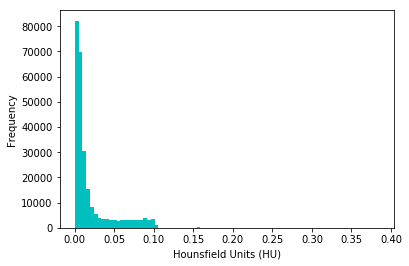

(512, 512)


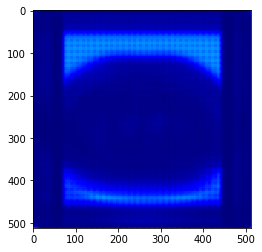

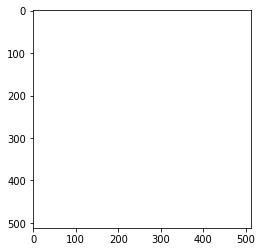

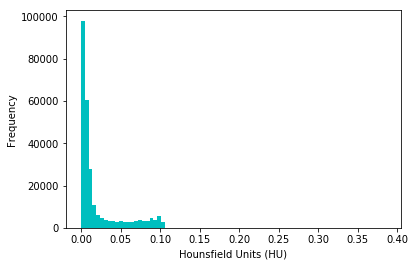

(512, 512)


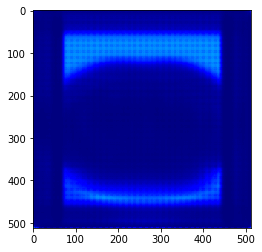

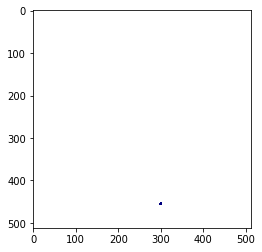

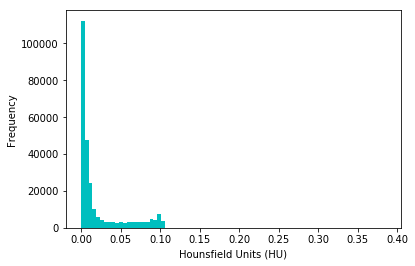

(512, 512)


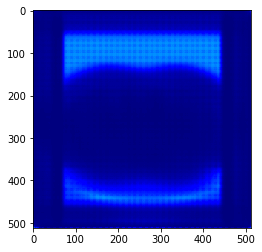

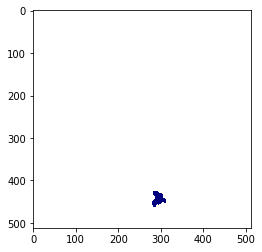

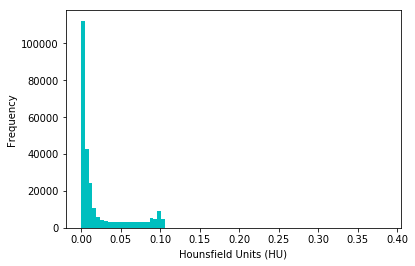

(512, 512)


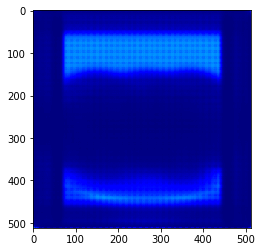

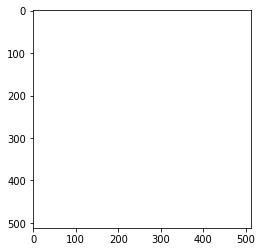

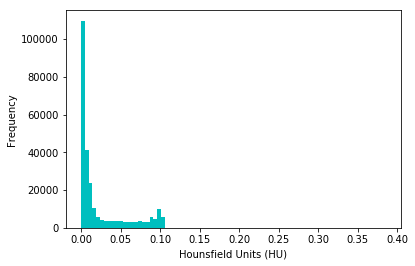

(512, 512)


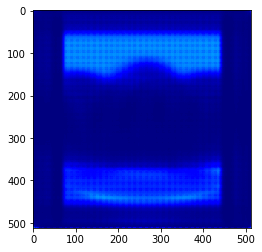

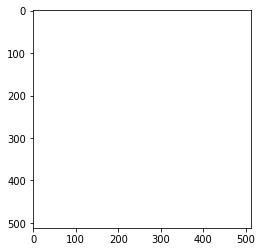

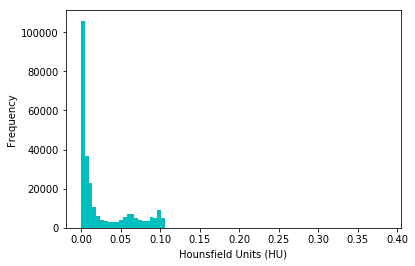

(512, 512)


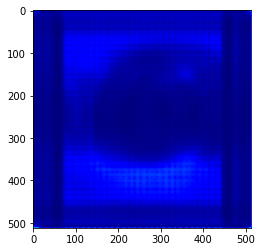

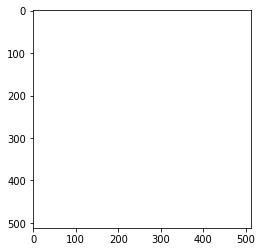

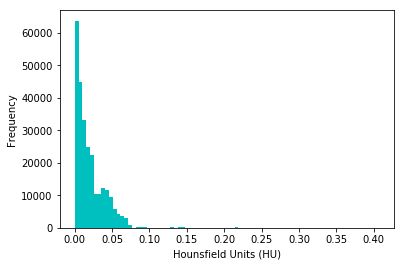

(512, 512)


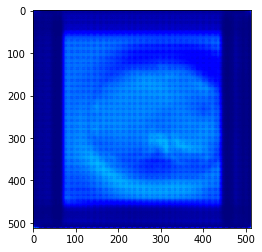

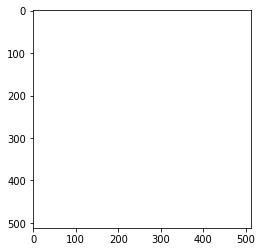

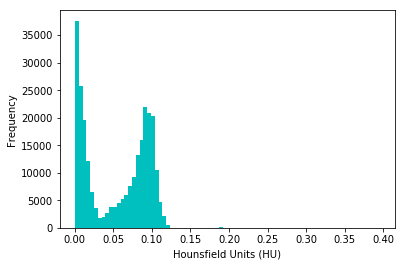

(512, 512)


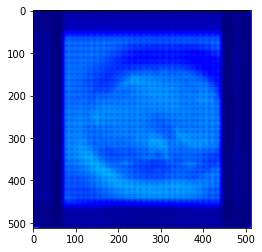

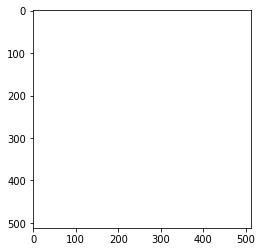

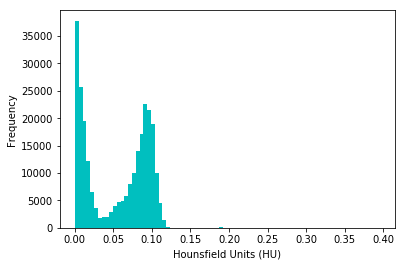

(512, 512)


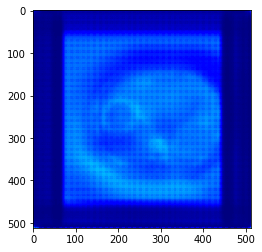

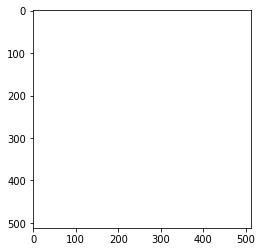

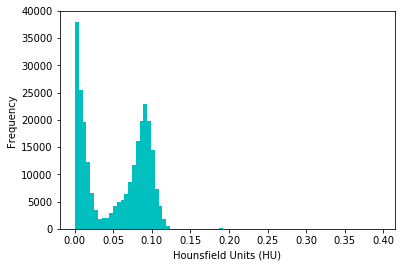

(512, 512)


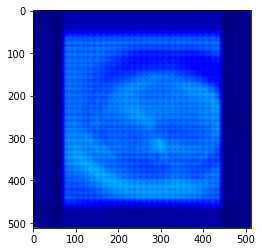

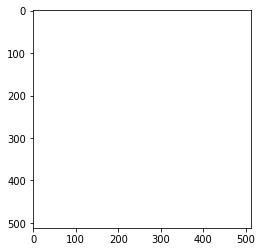

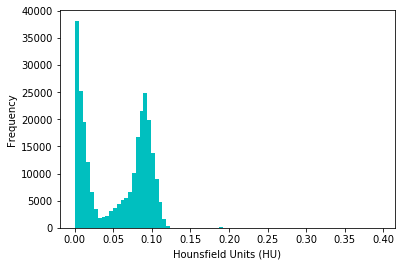

(512, 512)


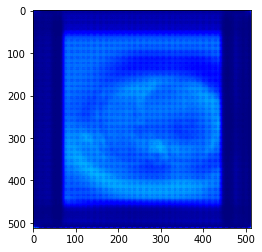

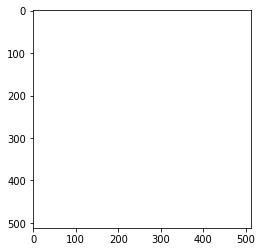

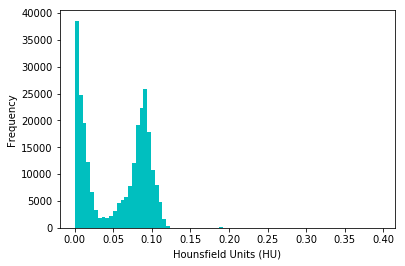

(512, 512)


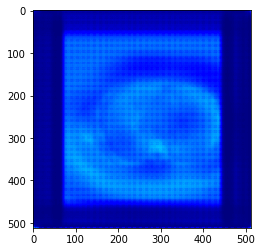

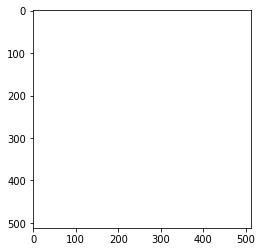

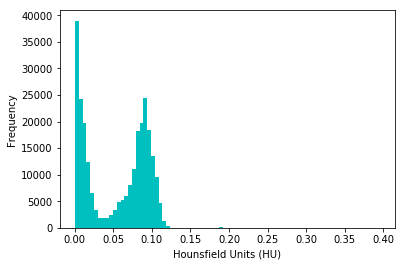

(512, 512)


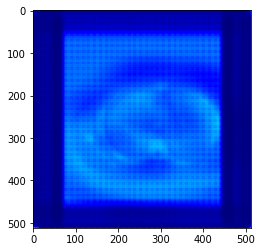

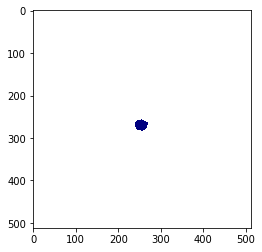

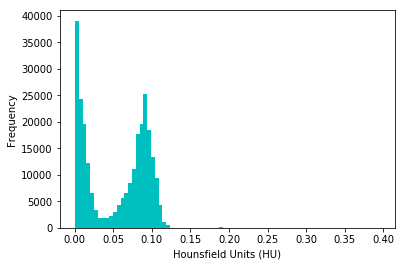

(512, 512)


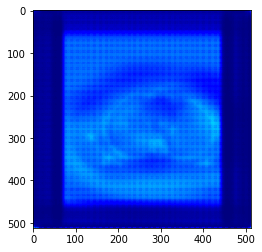

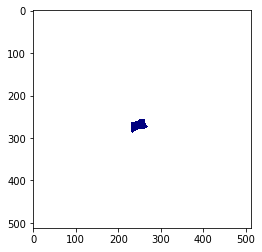

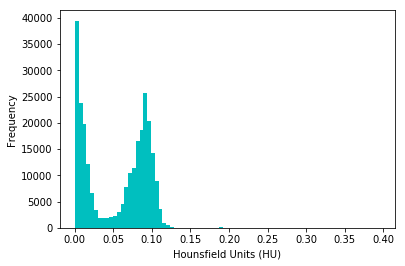

(512, 512)


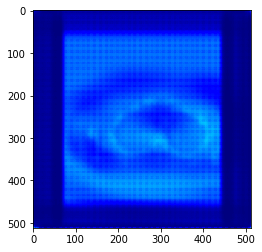

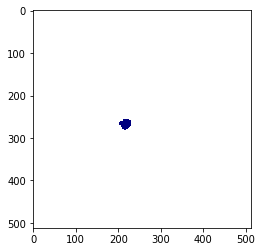

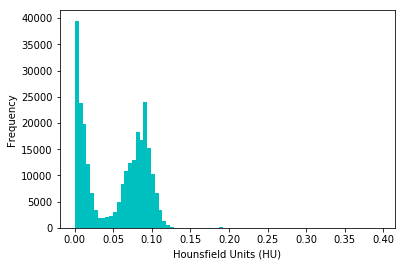

(512, 512)


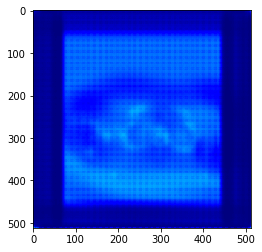

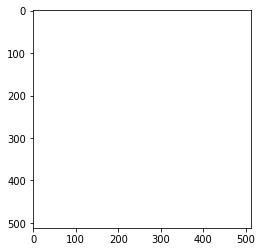

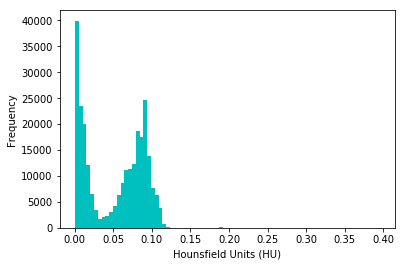

(512, 512)


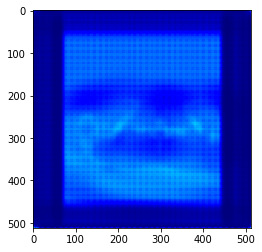

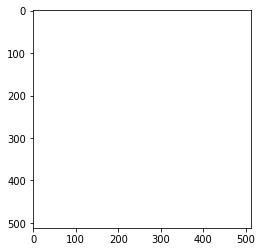

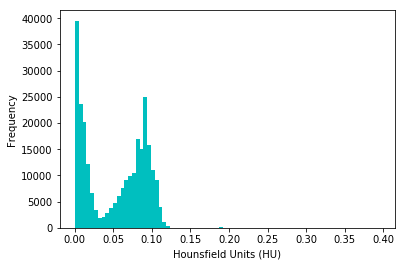

(512, 512)


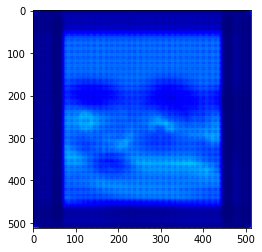

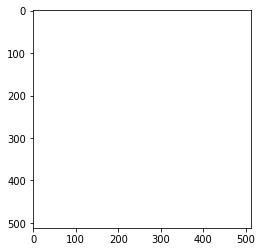

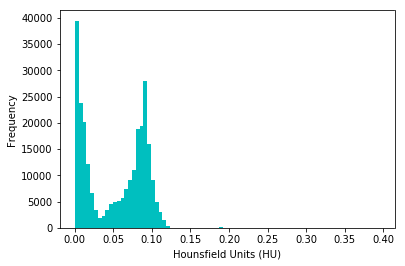

(512, 512)


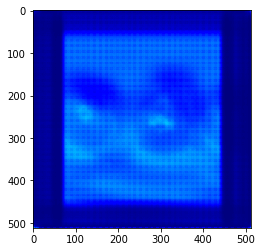

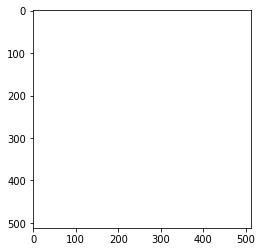

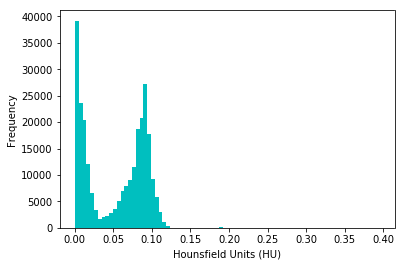

(512, 512)


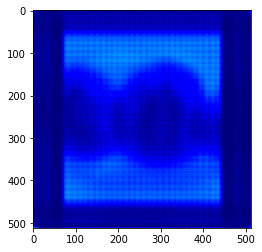

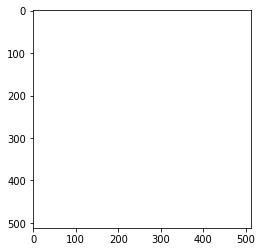

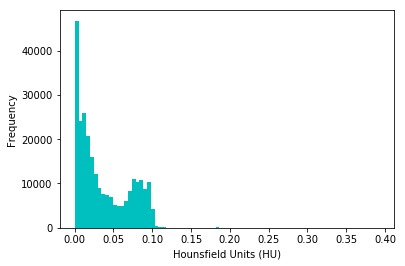

(512, 512)


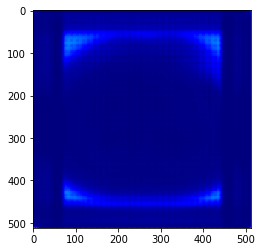

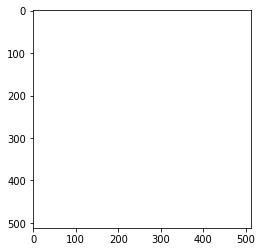

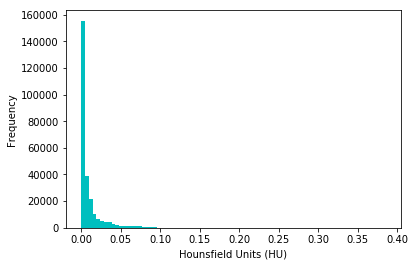

(512, 512)


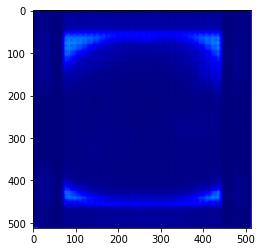

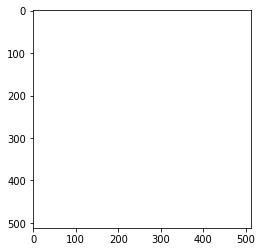

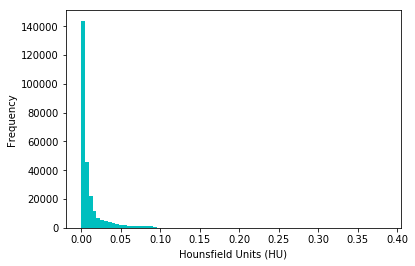

(512, 512)


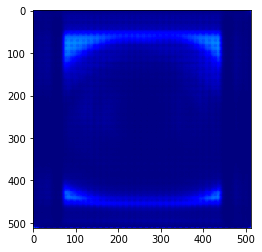

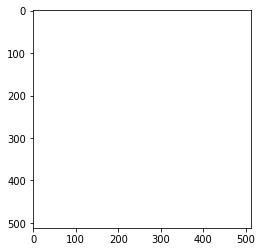

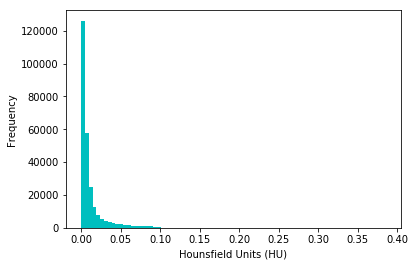

(512, 512)


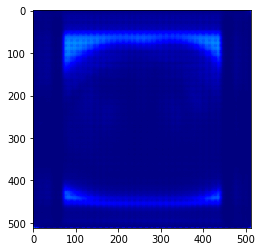

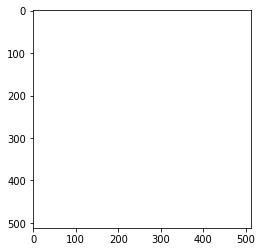

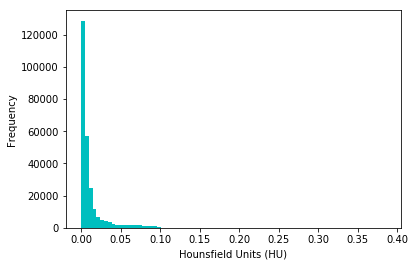

(512, 512)


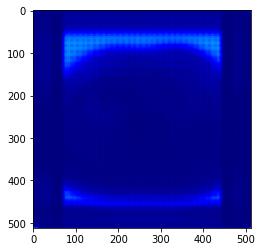

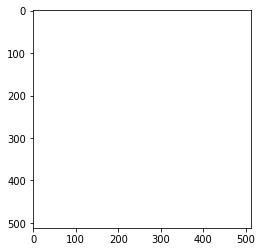

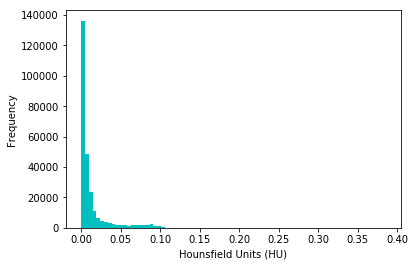

(512, 512)


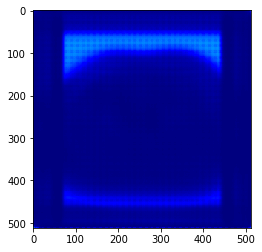

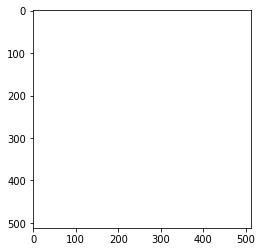

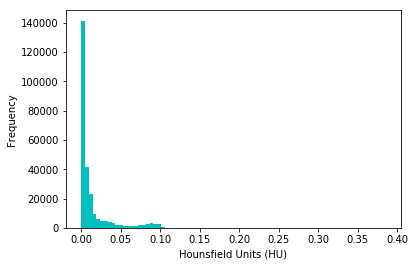

(512, 512)


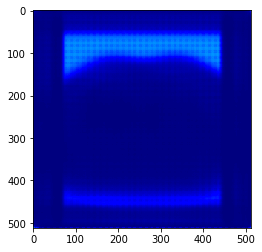

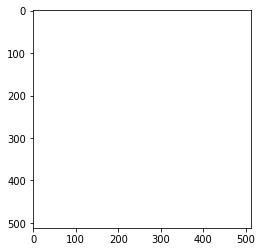

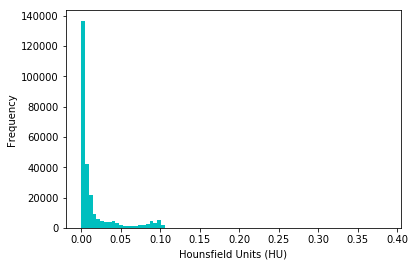

(512, 512)


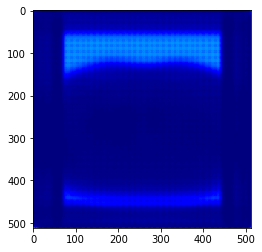

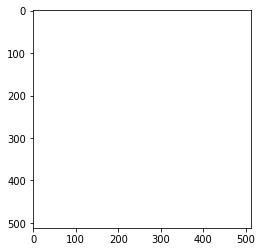

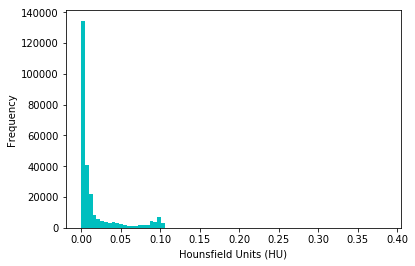

(512, 512)


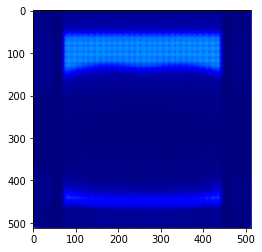

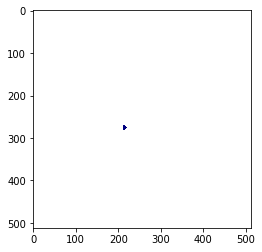

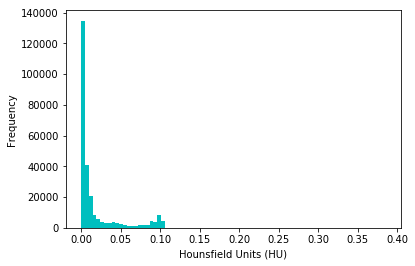

(512, 512)


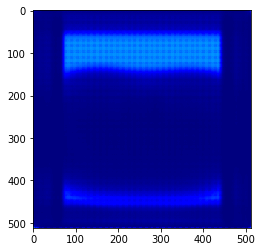

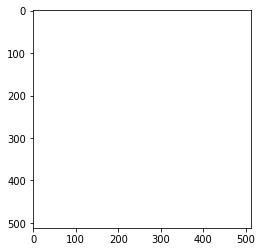

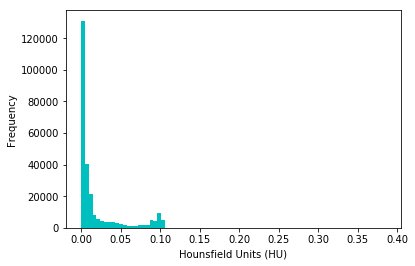

(512, 512)


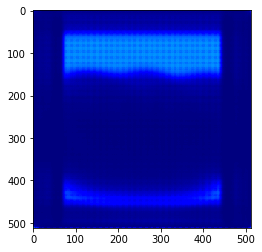

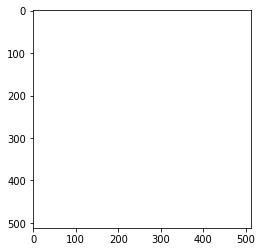

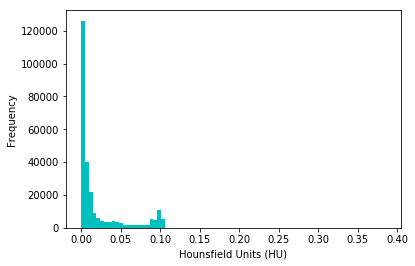

(512, 512)


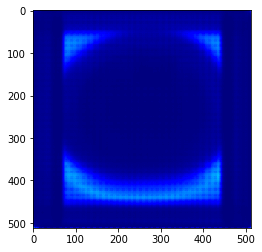

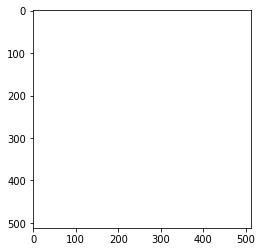

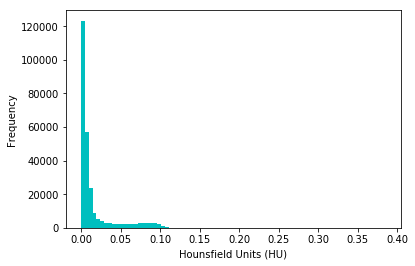

(512, 512)


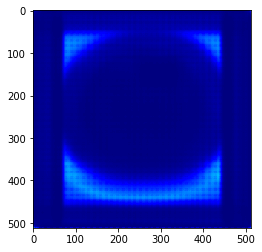

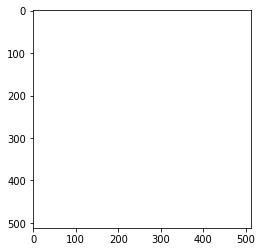

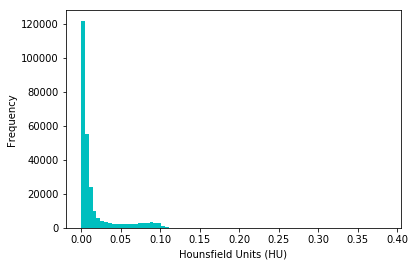

(512, 512)


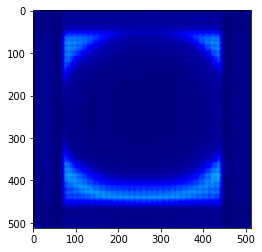

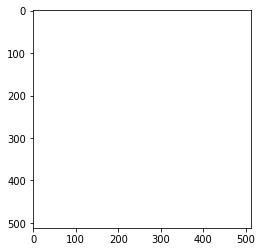

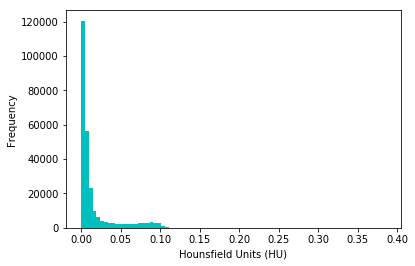

(512, 512)


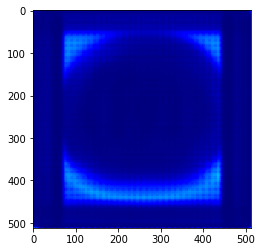

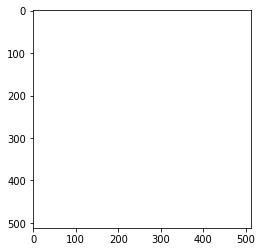

KeyboardInterrupt: ignored

In [0]:
#np.nonzero(preds_test)


tumor_slice_count = 0;

print(preds_test.shape)

for i,cntr in enumerate(preds_test_upsampled):
  if (np.count_nonzero(cntr) > 0) :
    tumor_slice_count += 1   
    print(cntr[:, :, 0].shape)
    
    img = cntr[:, :, 0]
    #img = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
    #img[img <= 100] = 0
   
    mask = Y_test[i][:, :, 0]
    img = np.ma.masked_where(img == 0, img) #mask the zero values.
    plt.imshow(img, cmap='jet', interpolation='none', alpha=None)
    plt.show()

    mask = np.ma.masked_where(mask == 0, mask) #mask the zero values.
    plt.imshow(mask, cmap='jet', interpolation='none', alpha=None)
    plt.show()
    

    
    plt.hist(img.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
    


print("Number of slices with Tumor: ", tumor_slice_count)

In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()